# **Find the most three stations crowded to set up the centers of the covid-19 vaccine using the MTA Turnstile DataSet**

# **Import packages**

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# **Load dataset**

In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210605, 210612, 210619, 210626, 210703, 210710, 210717, 210724, 210731, 210807, 210814, 210821, 210828, 210904]
turnstiles_df = get_data(week_nums)

In [4]:
#To show the top 10 rows in dataset
turnstiles_df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,04:00:00,REGULAR,7578740,2590327
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,08:00:00,REGULAR,7578749,2590340
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,12:00:00,REGULAR,7578789,2590386
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,16:00:00,REGULAR,7578897,2590418
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,20:00:00,REGULAR,7579021,2590439
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2021,00:00:00,REGULAR,7579078,2590451
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2021,04:00:00,REGULAR,7579084,2590452
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2021,08:00:00,REGULAR,7579085,2590454
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2021,12:00:00,REGULAR,7579093,2590493


In [5]:
#To show some information about dataset such as: Column name, datatype, No.of Rows.
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2932345 entries, 0 to 209734
Data columns (total 11 columns):
 #   Column                                                                Dtype 
---  ------                                                                ----- 
 0   C/A                                                                   object
 1   UNIT                                                                  object
 2   SCP                                                                   object
 3   STATION                                                               object
 4   LINENAME                                                              object
 5   DIVISION                                                              object
 6   DATE                                                                  object
 7   TIME                                                                  object
 8   DESC                                                           

In [6]:
turnstiles_df.describe()

,ENTRIES,EXITS
count,2.932345e+06,2.932345e+06
mean,4.163677e+07,3.327455e+07
std,2.183826e+08,1.918740e+08
min,0.000000e+00,0.000000e+00
25%,2.182180e+05,9.998500e+04
50%,1.404623e+06,8.551120e+05
75%,6.020096e+06,3.970328e+06
max,2.147417e+09,2.133797e+09


# **Pre-Processing**

Removing whitespace From column name

In [7]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

Missing values:

In [8]:
turnstiles_df.isna()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
209730,False,False,False,False,False,False,False,False,False,False,False
209731,False,False,False,False,False,False,False,False,False,False,False
209732,False,False,False,False,False,False,False,False,False,False,False
209733,False,False,False,False,False,False,False,False,False,False,False


In [9]:
print("Check if there are any missing values in Dataset ")
print(turnstiles_df.isnull().sum())

Check if there are any missing values in Dataset 
C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64


Duplicate:

In [10]:
print("Check if there are any duplicated values in dataset: \n")
dubl=turnstiles_df.duplicated()
print('number of duplicate = %d\n'%(dubl.sum()))

Check if there are any duplicated values in dataset: 

number of duplicate = 0



Create DATETIME column by combine day and time columns

In [11]:
turnstiles_df['DATETIME'] =pd.to_datetime(turnstiles_df.DATE +' '+ turnstiles_df.TIME, 
                    format='%m/%d/%Y %H:%M:%S')

turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325,2021-05-29 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,04:00:00,REGULAR,7578740,2590327,2021-05-29 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,08:00:00,REGULAR,7578749,2590340,2021-05-29 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,12:00:00,REGULAR,7578789,2590386,2021-05-29 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,16:00:00,REGULAR,7578897,2590418,2021-05-29 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
209730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,05:00:00,REGULAR,5554,638,2021-09-03 05:00:00
209731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,09:00:00,REGULAR,5554,638,2021-09-03 09:00:00
209732,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,13:00:00,REGULAR,5554,638,2021-09-03 13:00:00
209733,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,17:00:00,REGULAR,5554,638,2021-09-03 17:00:00


Remove non-REGULAR values from DESC column

In [12]:
turnstiles_df = turnstiles_df.drop(turnstiles_df.loc[turnstiles_df.DESC != 'REGULAR'].index)

Check the duplicates turnstile for a given datetime

In [13]:
(turnstiles_df
.groupby(['C/A','UNIT','SCP','STATION','DATETIME'])
.ENTRIES.count()
.reset_index()
.sort_values('ENTRIES', ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-05-29 00:00:00,1
1832762,R134,R272,01-00-03,28 ST,2021-06-04 21:00:00,1
1832764,R134,R272,01-00-03,28 ST,2021-06-05 13:00:00,1
1832765,R134,R272,01-00-03,28 ST,2021-06-05 17:00:00,1
1832766,R134,R272,01-00-03,28 ST,2021-06-05 21:00:00,1


In [14]:
turnstiles_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATETIME'],
                      inplace=True, ascending=True)

<ipython-input-14-14164244004b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATETIME'],


Create 3 columns:
1-previous datetime
2-previous entries
3-previous exits 

In [15]:
#Add shifted columns to show previous entries and exits
turnstiles_df[['PREV_DATETIME', "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_df
                                                .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])\
                                                       ['DATETIME','ENTRIES','EXITS']
                                                .apply(lambda grp: grp.shift(1)))

<ipython-input-15-afc38cfc7258>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_df[['PREV_DATETIME', "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_df
C:\Users\arwah\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Check null values after create 3 cloumns 

In [16]:
print(turnstiles_df.isnull().sum())

C/A                 0
UNIT                0
SCP                 0
STATION             0
LINENAME            0
DIVISION            0
DATE                0
TIME                0
DESC                0
ENTRIES             0
EXITS               0
DATETIME            0
PREV_DATETIME    5028
PREV_ENTRIES     5028
PREV_EXITS       5028
dtype: int64


Drop null values

In [17]:
turnstiles_df.dropna( axis=0, inplace=True)

<ipython-input-17-d8bac645ecd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df.dropna( axis=0, inplace=True)


Functions to count the daily entries

In [18]:
def daily_entries(row, max_count):
    count = row["ENTRIES"] - row["PREV_ENTRIES"]
    if count < 0:
        count = -count
    if count > max_count:
        count = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if count > max_count:
        return 0
    return count

Functions to count the daily exits

In [19]:
def daily_exits(row, max_count):
    countx = row["EXITS"] - row["PREV_EXITS"]
    if countx < 0:
        countx = -countx
    if countx > max_count:
        countx = min(row["EXITS"], row["PREV_EXITS"])
    if countx > max_count:
        return 0
    return countx

If the count more than 1M, then the counter might have been reset!

In [20]:
turnstiles_df["TOTAL_ENTRIES"] = turnstiles_df.apply(daily_entries, axis=1, max_count=100000)
turnstiles_df["TOTAL_EXITS"] = turnstiles_df.apply(daily_exits, axis=1, max_count=100000)

<ipython-input-20-40068c5463f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df["TOTAL_ENTRIES"] = turnstiles_df.apply(daily_entries, axis=1, max_count=100000)
<ipython-input-20-40068c5463f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df["TOTAL_EXITS"] = turnstiles_df.apply(daily_exits, axis=1, max_count=100000)


Total of entries and exits (Traffic) after outliers are removed

In [21]:
turnstiles_df = turnstiles_df[(np.abs(stats.zscore(turnstiles_df["TOTAL_ENTRIES"])) < 3)] 
turnstiles_df = turnstiles_df[(np.abs(stats.zscore(turnstiles_df["TOTAL_EXITS"])) < 3)] 
turnstiles_df["TOTAL_TRAFFIC"] = turnstiles_df["TOTAL_EXITS"] + turnstiles_df["TOTAL_ENTRIES"]

In [22]:
turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,04:00:00,REGULAR,7578740,2590327,2021-05-29 04:00:00,2021-05-29 00:00:00,7578734.0,2590325.0,6.0,2.0,8.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,08:00:00,REGULAR,7578749,2590340,2021-05-29 08:00:00,2021-05-29 04:00:00,7578740.0,2590327.0,9.0,13.0,22.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,12:00:00,REGULAR,7578789,2590386,2021-05-29 12:00:00,2021-05-29 08:00:00,7578749.0,2590340.0,40.0,46.0,86.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,16:00:00,REGULAR,7578897,2590418,2021-05-29 16:00:00,2021-05-29 12:00:00,7578789.0,2590386.0,108.0,32.0,140.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,20:00:00,REGULAR,7579021,2590439,2021-05-29 20:00:00,2021-05-29 16:00:00,7578897.0,2590418.0,124.0,21.0,145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,05:00:00,REGULAR,5554,638,2021-09-03 05:00:00,2021-09-03 01:00:00,5554.0,638.0,0.0,0.0,0.0
209731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,09:00:00,REGULAR,5554,638,2021-09-03 09:00:00,2021-09-03 05:00:00,5554.0,638.0,0.0,0.0,0.0
209732,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,13:00:00,REGULAR,5554,638,2021-09-03 13:00:00,2021-09-03 09:00:00,5554.0,638.0,0.0,0.0,0.0
209733,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/03/2021,17:00:00,REGULAR,5554,638,2021-09-03 17:00:00,2021-09-03 13:00:00,5554.0,638.0,0.0,0.0,0.0


TOTAL_TRAFFIC after remove the outliers

In [23]:
turnstiles_df = turnstiles_df[(np.abs(stats.zscore(turnstiles_df['TOTAL_TRAFFIC'])) < 3)] #remove total traffic outliers that are 3 sigmas from mean

# **Top 3 stations are more crowded**

Find station_daily for each station daily and TOTAL TRAFFIC

In [24]:
station_daily = turnstiles_df.groupby(["STATION","DATE"])[['TOTAL_TRAFFIC']].sum().reset_index()
station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC
0,1 AV,05/29/2021,10973.0
1,1 AV,05/30/2021,13397.0
2,1 AV,05/31/2021,12571.0
3,1 AV,06/01/2021,15752.0
4,1 AV,06/02/2021,16907.0


Find the sum TOTAL TRAFFIC for each station

In [25]:
stations_total = station_daily.groupby('STATION').sum()\
    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    .reset_index()

stations_total.head(3)

,STATION,TOTAL_TRAFFIC
0,34 ST-PENN STA,8107596.0
1,23 ST,5172795.0
2,GRD CNTRL-42 ST,5038151.0


Using the sum to find the top three stations 
using round(0) to return the nearest integer

In [26]:
station_avg = station_daily.groupby('STATION').sum().round(0)\
    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    .reset_index()

Plot the top 3 stations are more crowded 

C:\Users\arwah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, ' Total Traffic')

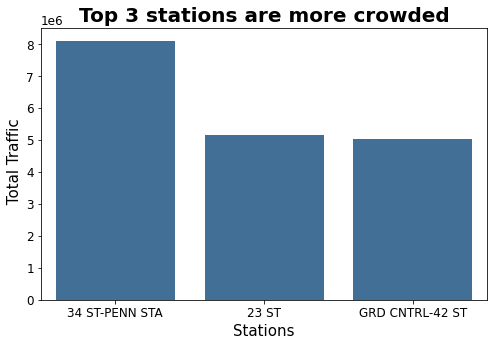

In [38]:
top_three_stations_avg_daily = station_avg[:3]
plt.figure(figsize=[8,5])

ax = sns.barplot('STATION', 'TOTAL_TRAFFIC', data=top_three_stations_avg_daily,color= '#3470A3')

plt.title('Top 3 stations are more crowded', size=20, weight='bold')
plt.xlabel("Stations", size=15)
plt.ylabel(" Total Traffic", size=15)

#plt.savefig('topthree.png') # To save the plot, i sued it in google coolab.
#files.download('topthree.png') # To download the plot to your computer, plt.figure(figsize=[10,10])

# **Find the Top 3 stations are more cowded in weekday and weekend**

In [29]:
turnstiles_df['DATE'] = pd.to_datetime(turnstiles_df['DATE'], cache=True)
turnstiles_df['Week_Day'] = turnstiles_df['DATE'].dt.day_name() #New column to identify the name of day.
turnstiles_df

<ipython-input-29-8906c0c7d920>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df['DATE'] = pd.to_datetime(turnstiles_df['DATE'], cache=True)
<ipython-input-29-8906c0c7d920>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df['Week_Day'] = turnstiles_df['DATE'].dt.day_name() #New column to identify the name of day.


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC,Week_Day
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,04:00:00,REGULAR,7578740,2590327,2021-05-29 04:00:00,2021-05-29 00:00:00,7578734.0,2590325.0,6.0,2.0,8.0,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,08:00:00,REGULAR,7578749,2590340,2021-05-29 08:00:00,2021-05-29 04:00:00,7578740.0,2590327.0,9.0,13.0,22.0,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,12:00:00,REGULAR,7578789,2590386,2021-05-29 12:00:00,2021-05-29 08:00:00,7578749.0,2590340.0,40.0,46.0,86.0,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,16:00:00,REGULAR,7578897,2590418,2021-05-29 16:00:00,2021-05-29 12:00:00,7578789.0,2590386.0,108.0,32.0,140.0,Saturday
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,20:00:00,REGULAR,7579021,2590439,2021-05-29 20:00:00,2021-05-29 16:00:00,7578897.0,2590418.0,124.0,21.0,145.0,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,05:00:00,REGULAR,5554,638,2021-09-03 05:00:00,2021-09-03 01:00:00,5554.0,638.0,0.0,0.0,0.0,Friday
209731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,09:00:00,REGULAR,5554,638,2021-09-03 09:00:00,2021-09-03 05:00:00,5554.0,638.0,0.0,0.0,0.0,Friday
209732,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,13:00:00,REGULAR,5554,638,2021-09-03 13:00:00,2021-09-03 09:00:00,5554.0,638.0,0.0,0.0,0.0,Friday
209733,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,17:00:00,REGULAR,5554,638,2021-09-03 17:00:00,2021-09-03 13:00:00,5554.0,638.0,0.0,0.0,0.0,Friday


Identify the weekend and weekday

In [30]:
turnstiles_df['WEEKEND'] = (turnstiles_df['Week_Day']
                                   .apply(lambda x: 'WEEKEND' 
                                          if (x == 'Saturday' or x == 'Sunday') 
                                          else 'WEEKDAY'))

turnstiles_df

<ipython-input-30-c2df27445811>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df['WEEKEND'] = (turnstiles_df['Week_Day']


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC,Week_Day,WEEKEND
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,04:00:00,REGULAR,7578740,2590327,2021-05-29 04:00:00,2021-05-29 00:00:00,7578734.0,2590325.0,6.0,2.0,8.0,Saturday,WEEKEND
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,08:00:00,REGULAR,7578749,2590340,2021-05-29 08:00:00,2021-05-29 04:00:00,7578740.0,2590327.0,9.0,13.0,22.0,Saturday,WEEKEND
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,12:00:00,REGULAR,7578789,2590386,2021-05-29 12:00:00,2021-05-29 08:00:00,7578749.0,2590340.0,40.0,46.0,86.0,Saturday,WEEKEND
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,16:00:00,REGULAR,7578897,2590418,2021-05-29 16:00:00,2021-05-29 12:00:00,7578789.0,2590386.0,108.0,32.0,140.0,Saturday,WEEKEND
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,20:00:00,REGULAR,7579021,2590439,2021-05-29 20:00:00,2021-05-29 16:00:00,7578897.0,2590418.0,124.0,21.0,145.0,Saturday,WEEKEND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,05:00:00,REGULAR,5554,638,2021-09-03 05:00:00,2021-09-03 01:00:00,5554.0,638.0,0.0,0.0,0.0,Friday,WEEKDAY
209731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,09:00:00,REGULAR,5554,638,2021-09-03 09:00:00,2021-09-03 05:00:00,5554.0,638.0,0.0,0.0,0.0,Friday,WEEKDAY
209732,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,13:00:00,REGULAR,5554,638,2021-09-03 13:00:00,2021-09-03 09:00:00,5554.0,638.0,0.0,0.0,0.0,Friday,WEEKDAY
209733,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-09-03,17:00:00,REGULAR,5554,638,2021-09-03 17:00:00,2021-09-03 13:00:00,5554.0,638.0,0.0,0.0,0.0,Friday,WEEKDAY


In [31]:
station_avg_weekend = turnstiles_df[turnstiles_df.WEEKEND=='WEEKEND'].groupby([ 'STATION','WEEKEND'])[['TOTAL_TRAFFIC']].sum().round(0).reset_index().head(3)
station_avg_weekday = turnstiles_df[turnstiles_df.WEEKEND=='WEEKDAY'].groupby([ 'STATION','WEEKEND']).TOTAL_TRAFFIC.sum().round(0).reset_index().head(3)
station_avg_weekend

,STATION,WEEKEND,TOTAL_TRAFFIC
0,1 AV,WEEKEND,438577.0
1,103 ST,WEEKEND,356273.0
2,103 ST-CORONA,WEEKEND,386895.0


In [32]:
station_avg_weekday

,STATION,WEEKEND,TOTAL_TRAFFIC
0,1 AV,WEEKDAY,1165539.0
1,103 ST,WEEKDAY,1275247.0
2,103 ST-CORONA,WEEKDAY,911482.0


In [33]:
station_avg_weekday.sort_values(['TOTAL_TRAFFIC'], ascending=False)\
    .reset_index().head(10)

,index,STATION,WEEKEND,TOTAL_TRAFFIC
0,1,103 ST,WEEKDAY,1275247.0
1,0,1 AV,WEEKDAY,1165539.0
2,2,103 ST-CORONA,WEEKDAY,911482.0


In [34]:
station_avg_weekend['TOTAL_TRAFFIC_WEEKDAY']=station_avg_weekday['TOTAL_TRAFFIC']
station_avg_weekend['TOTAL_TRAFFIC_WEEKEND']=station_avg_weekend['TOTAL_TRAFFIC']
station_avg_weekend.drop(['TOTAL_TRAFFIC','WEEKEND'], axis=1,inplace=True)
station_avg_weekend.sort_values(['TOTAL_TRAFFIC_WEEKDAY', 'TOTAL_TRAFFIC_WEEKEND'], ascending=False)\
    .reset_index()
station_avg_df=station_avg_weekend.head(3)
station_avg_df

,STATION,TOTAL_TRAFFIC_WEEKDAY,TOTAL_TRAFFIC_WEEKEND
0,1 AV,1165539.0,438577.0
1,103 ST,1275247.0,356273.0
2,103 ST-CORONA,911482.0,386895.0


Plot the traffic in the top 3 stations in each of weekend and weekday

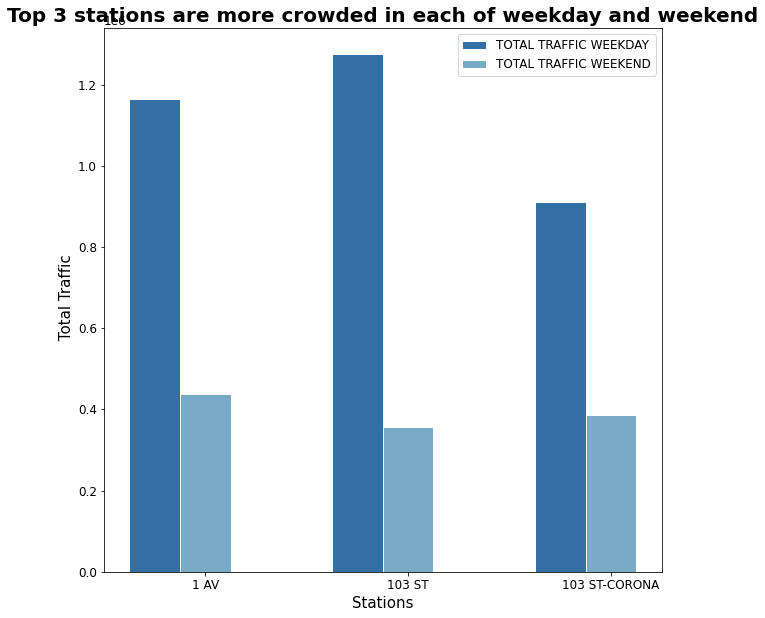

In [36]:
plt.figure(figsize=[10,10])
barWidth = 0.25
r1 = np.arange(len(station_avg_df['TOTAL_TRAFFIC_WEEKDAY']))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1,station_avg_df['TOTAL_TRAFFIC_WEEKDAY'], color= '#3470A3', width=barWidth, edgecolor='white', label='TOTAL TRAFFIC WEEKDAY')
plt.bar(r2,station_avg_df['TOTAL_TRAFFIC_WEEKEND'], color='#79ABC9', width=barWidth, edgecolor='white', label='TOTAL TRAFFIC WEEKEND')

plt.xticks([r + barWidth for r in range(len(station_avg_df['TOTAL_TRAFFIC_WEEKEND']))], station_avg_df['STATION'])
plt.title('Top 3 stations are more crowded in each of weekday and weekend', size=20, weight='bold')
plt.rcParams['font.size']= 12
plt.xlabel("Stations", size=15)
plt.ylabel(" Total Traffic", size=15)
plt.legend()
plt.show()
#plt.savefig('topthreeweek.png') # To save the plot, i used it in google colab.
#files.download('topthreeweek.png') # To download the plot to your computer, i used it in google colab. 